# This script uses the data obtained in the script preprocess_altimeter_data 
#  1. Get insitu observations from stations and get processed altimeter data
# - Calculate and Plot accuracies between isitu and altimeter data
# - Plot comparisons between altimeter and insitu observations 
# - Plot time series altimeter and station


## 0. Import libraries and resources

In [1]:
from ground_data import GroundObservations
import geopandas as gpd
import platform
from ts_preprocesing import *#get_date_time_cols
from ts_plots import *
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
from icecream import ic
from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pytz
from pytz import timezone
import timeit
from datetime import datetime
import ipywidgets as widgets 
utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

# Get prefix of data files. 
### The cell below does not to be run everytime. Run only if the textbox does not appear. The prefix is the date in which files were generated

In [2]:
#Entre the date of the files 
txt=widgets.Text(
    value='Format: %Y%m%d_%H_%M',
    placeholder='Add the file posfix',
    description='File postfix:',
    disabled=False
)

btn=widgets.Button(
    description='Add time of figure',
    disabled=False
)

# box=VBox([txt,btn])
display(txt, btn)


Text(value='Format: %Y%m%d_%H_%M', description='File postfix:', placeholder='Add the file posfix')

Button(description='Add time of figure', style=ButtonStyle())

In [ ]:
# Previous cell not working at the moment using the last date

In [5]:
print(txt.value)

20230912_10_39


#  1. Get insitu observations from stations and get processed altimeter data

In [3]:
time_fig= '20230912_10_39'# txt.value#"%Y%m%d_%H_%M"
df_final_ground=pd.read_csv('../data/results/preprossed_ground_data_'+time_fig+'.csv', sep=',', low_memory=False, parse_dates=['date'])
df_final_altis=pd.read_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',',low_memory=False, parse_dates=['date'])

In [4]:
df_final_altis_all=df_final_altis.copy()

In [5]:
#Creating paper group of lakes. It helps to split the data in the plot
# A. Get only the data for the paper 
# B. Label data to form the group of lakes

df_final_altis=df_final_altis.loc[df_final_altis['for_paper']=='Y'].copy()
#locss lakes
locss_g=df_final_altis.loc[df_final_altis['source']=='LOCSS', 'gauge_id'].unique()
#ARHN and USGS
off_nat_g=df_final_altis.loc[(df_final_altis['source']=='ARHN')|(df_final_altis['source']=='USGS'), 'gauge_id'].unique()
# Reservoirs
res_g=df_final_altis.loc[df_final_altis['source']=='RVBR', 'gauge_id'].unique()
dic_groups={'LOCSS':locss_g,'OFNAT':off_nat_g,'RVBR':res_g}


In [9]:
# dic_groups

### Fix lake names for Brazil. Precise special characteres for brazilian reservoirs

In [6]:
dic_lake_names={'12056':'Açude Boa Vista', 
               '12036': 'Açude Atalho',
               '12327': 'Açude Petronio Portela',
               '19126': 'UHE Xingó',
               '12030': 'Açude Araras',
               '12327':'Açude Petrônio Portela'}

In [11]:
# Test
# [dic_lake_names[x] for x in dic_lake_names.keys()] 
# for k in dic_lake_names.keys():
#     print(dic_lake_names[k])

### Configure the plot's output
### Plot to publish 

In [31]:
#If everything will restart put 0, otherwise put a different number. This restars the dataframes with the output
start=0
#save plots?
save_plot=True
#Plot?
show_plot=True
#save results
save_res=False

In [105]:
# Add a radio button for A. All insitu; B. Matching insitu
# Add an option for A. only significant correlation B. All comparisons
txt_g=widgets.Text(
    value='LOCSS',
    placeholder='Add the group',
    description='Group data:',
    disabled=False
)

btn_g=widgets.Button(
    description='Define'
)
display(txt_g, btn_g)

def on_button_clicked(b):
    print("Value group ",txt_g.value)
    group=txt_g.value

btn_g.on_click(on_button_clicked)

Text(value='LOCSS', description='Group data:', placeholder='Add the group')

Button(description='Define', style=ButtonStyle())

In [113]:
#Pending programming event
group=txt_g.value 
group

'RVBR'

In [47]:
group='LOCSS'

In [9]:
df.gauge_altis.unique().shape

(15,)

In [48]:
# dic_groups={'LOCSS':locss_g,'OFNAT':off_nat_g,'RVBR':res_g}
# group='LOCSS'

if group =='':
    df=df_final_altis.copy()
    
    filtered_gauge='12030'
    df_a=df.loc[df['gauge_id']==filtered_gauge].copy()
    df_a=df_a.loc[df_a['date']>'2018-07-01']
    df_o=df.loc[df['gauge_id']!=filtered_gauge].copy()
    df=pd.concat([df_o, df_a], axis=0)
    for k in dic_lake_names.keys():
        df.loc[df['gauge_id']==k,'lake_name']=dic_lake_names[k]
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=8
    col_f=5
    w=30
    h=35
    # df.loc[df['gauge_id']=='FDN2', 'lake_name']='Lake Phelps'
    # df.loc[df['gauge_id']=='PHN2', 'lake_name']='Lake Phelps East'
    # df.loc[df['gauge_id']=='VCN2', 'lake_name']='Lake Mattamuskeet East'
elif group=='OFNAT':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=4
    col_f=3
    w=25
    h=20    
elif group=='LOCSS':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=5
    col_f=3
    w=25#15
    h=20
    # df.loc[df['gauge_id']=='FDN2', 'lake_name']='Lake Phelps'
    # df.loc[df['gauge_id']=='PHN2', 'lake_name']='Lake Phelps East'
    # df.loc[df['gauge_id']=='VCN2', 'lake_name']='Lake Mattamuskeet East'
    ##Filter
    # filter_out=['MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549','FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577']
    # df=df.loc[~df['gauge_altis'].isin(filter_out)].copy()
elif group=='RVBR':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    
    for k in dic_lake_names.keys():
        df.loc[df['gauge_id']==k,'lake_name']=dic_lake_names[k]

    filtered_gauge='12030'
    df_a=df.loc[df['gauge_id']=='12030'].copy()
    df_a=df_a.loc[df_a['date']>'2018-07-01']
    df_o=df.loc[df['gauge_id']!='12030'].copy()
    df=pd.concat([df_o, df_a], axis=0)
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
        #Filter out OLTC failure 
    filter_out=['12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764', '19069_AlTiS_TimeSeries_Sentinel-3A_0190_S2751']
    df=df.loc[~df['gauge_altis'].isin(filter_out)].copy()
    #filter Araras
    
    row_f=4
    col_f=3
    w=25
    h=20
    
df_ground_cp=df_final_ground.loc[df_final_ground['for_paper']=='Y'].copy()
df_ground_cp['gauge_altis']=df_ground_cp.gauge_id +'_'+df_ground_cp.name_altis

if group=='' or group=='RVBR':
    df_ground_cp_a=df_ground_cp.loc[df_ground_cp['gauge_id']=='12030'].copy() ##Filter dates in Araras reservoir
    df_ground_cp_o=df_ground_cp.loc[df_ground_cp['gauge_id']!='12030'].copy() ##Separate that reservoir del resto 
    df_ground_cp_a=df_ground_cp_a.loc[df_ground_cp_a['date']>'2018-07-01'].copy()
    df_ground_cp=pd.concat([df_ground_cp_o, df_ground_cp_a], axis=0)
    
df_final_ground['gauge_altis']=df_final_ground.gauge_id +'_'+df_final_ground.name_altis
df_validation=df.copy()

In [77]:
df.gauge_id.unique()

array(['12056', '12036', '19060', '19069', '19126', '12327', '12030'],
      dtype=object)

In [39]:


# df_ground_cp['date']=
# pd.to_datetime(df_ground_cp['date'], format='%Y-%m-%d %H:%M:%S')

#### Add letter for each panel

In [10]:
# dtale.show(df_validation.head())
letters=[chr(x) for x in [*range(65, 91),*range(97, 123)]]
# [chr(x) for x in range(97, 123)]


In [33]:
len(letters)

52

In [ ]:
# Decide on which data to plot 
# mp for matching points
# go for in-situ observations

In [42]:
# what to plot?

#Matching in-situ points
wtp='mp'


In [14]:
#Ground observations points (default)
wtp='gp'

21_S3A_318_1
1 BLB2_AlTiS_TimeSeries_Sentinel-3A_0636_N2354
7320428982_S3B_346_1
2 BTN2_AlTiS_TimeSeries_Sentinel-3B_0691_N3466
7320417422_S3A_18_1
3 CFN2_AlTiS_TimeSeries_Sentinel-3A_0035_N3493
1052515_S3B_311_1
4 QUL2_AlTiS_TimeSeries_Sentinel-3B_0622_N4194
7421066862_S3B_311_1
5 YSL2_AlTiS_TimeSeries_Sentinel-3B_0622_N4234
865120_S3A_176_1
6 HMT2_AlTiS_TimeSeries_Sentinel-3A_0351_N5346
4530720592_S3A_261_1
7 KHB2_AlTiS_TimeSeries_Sentinel-3A_0522_N2294
7320415112_S3B_11_1
8 VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549
7320415112_S3B_11_1
9 MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549
7320414542_S3A_75_1
10 PHN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577
7320414542_S3A_75_1
11 FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577
7830177462_S3A_13_1
12 SAW2_AlTiS_TimeSeries_Sentinel-3A_0026_N4756
7820034152_S3A_319_1
13 WEW2_AlTiS_TimeSeries_Sentinel-3A_0637_N4783
1052865_S3B_275_1
14 SLL2_AlTiS_TimeSeries_Sentinel-3B_0549_N4183
22_S3A_97_1
15 TAB2_AlTiS_TimeSeries_Sentinel-3A_0193_N25

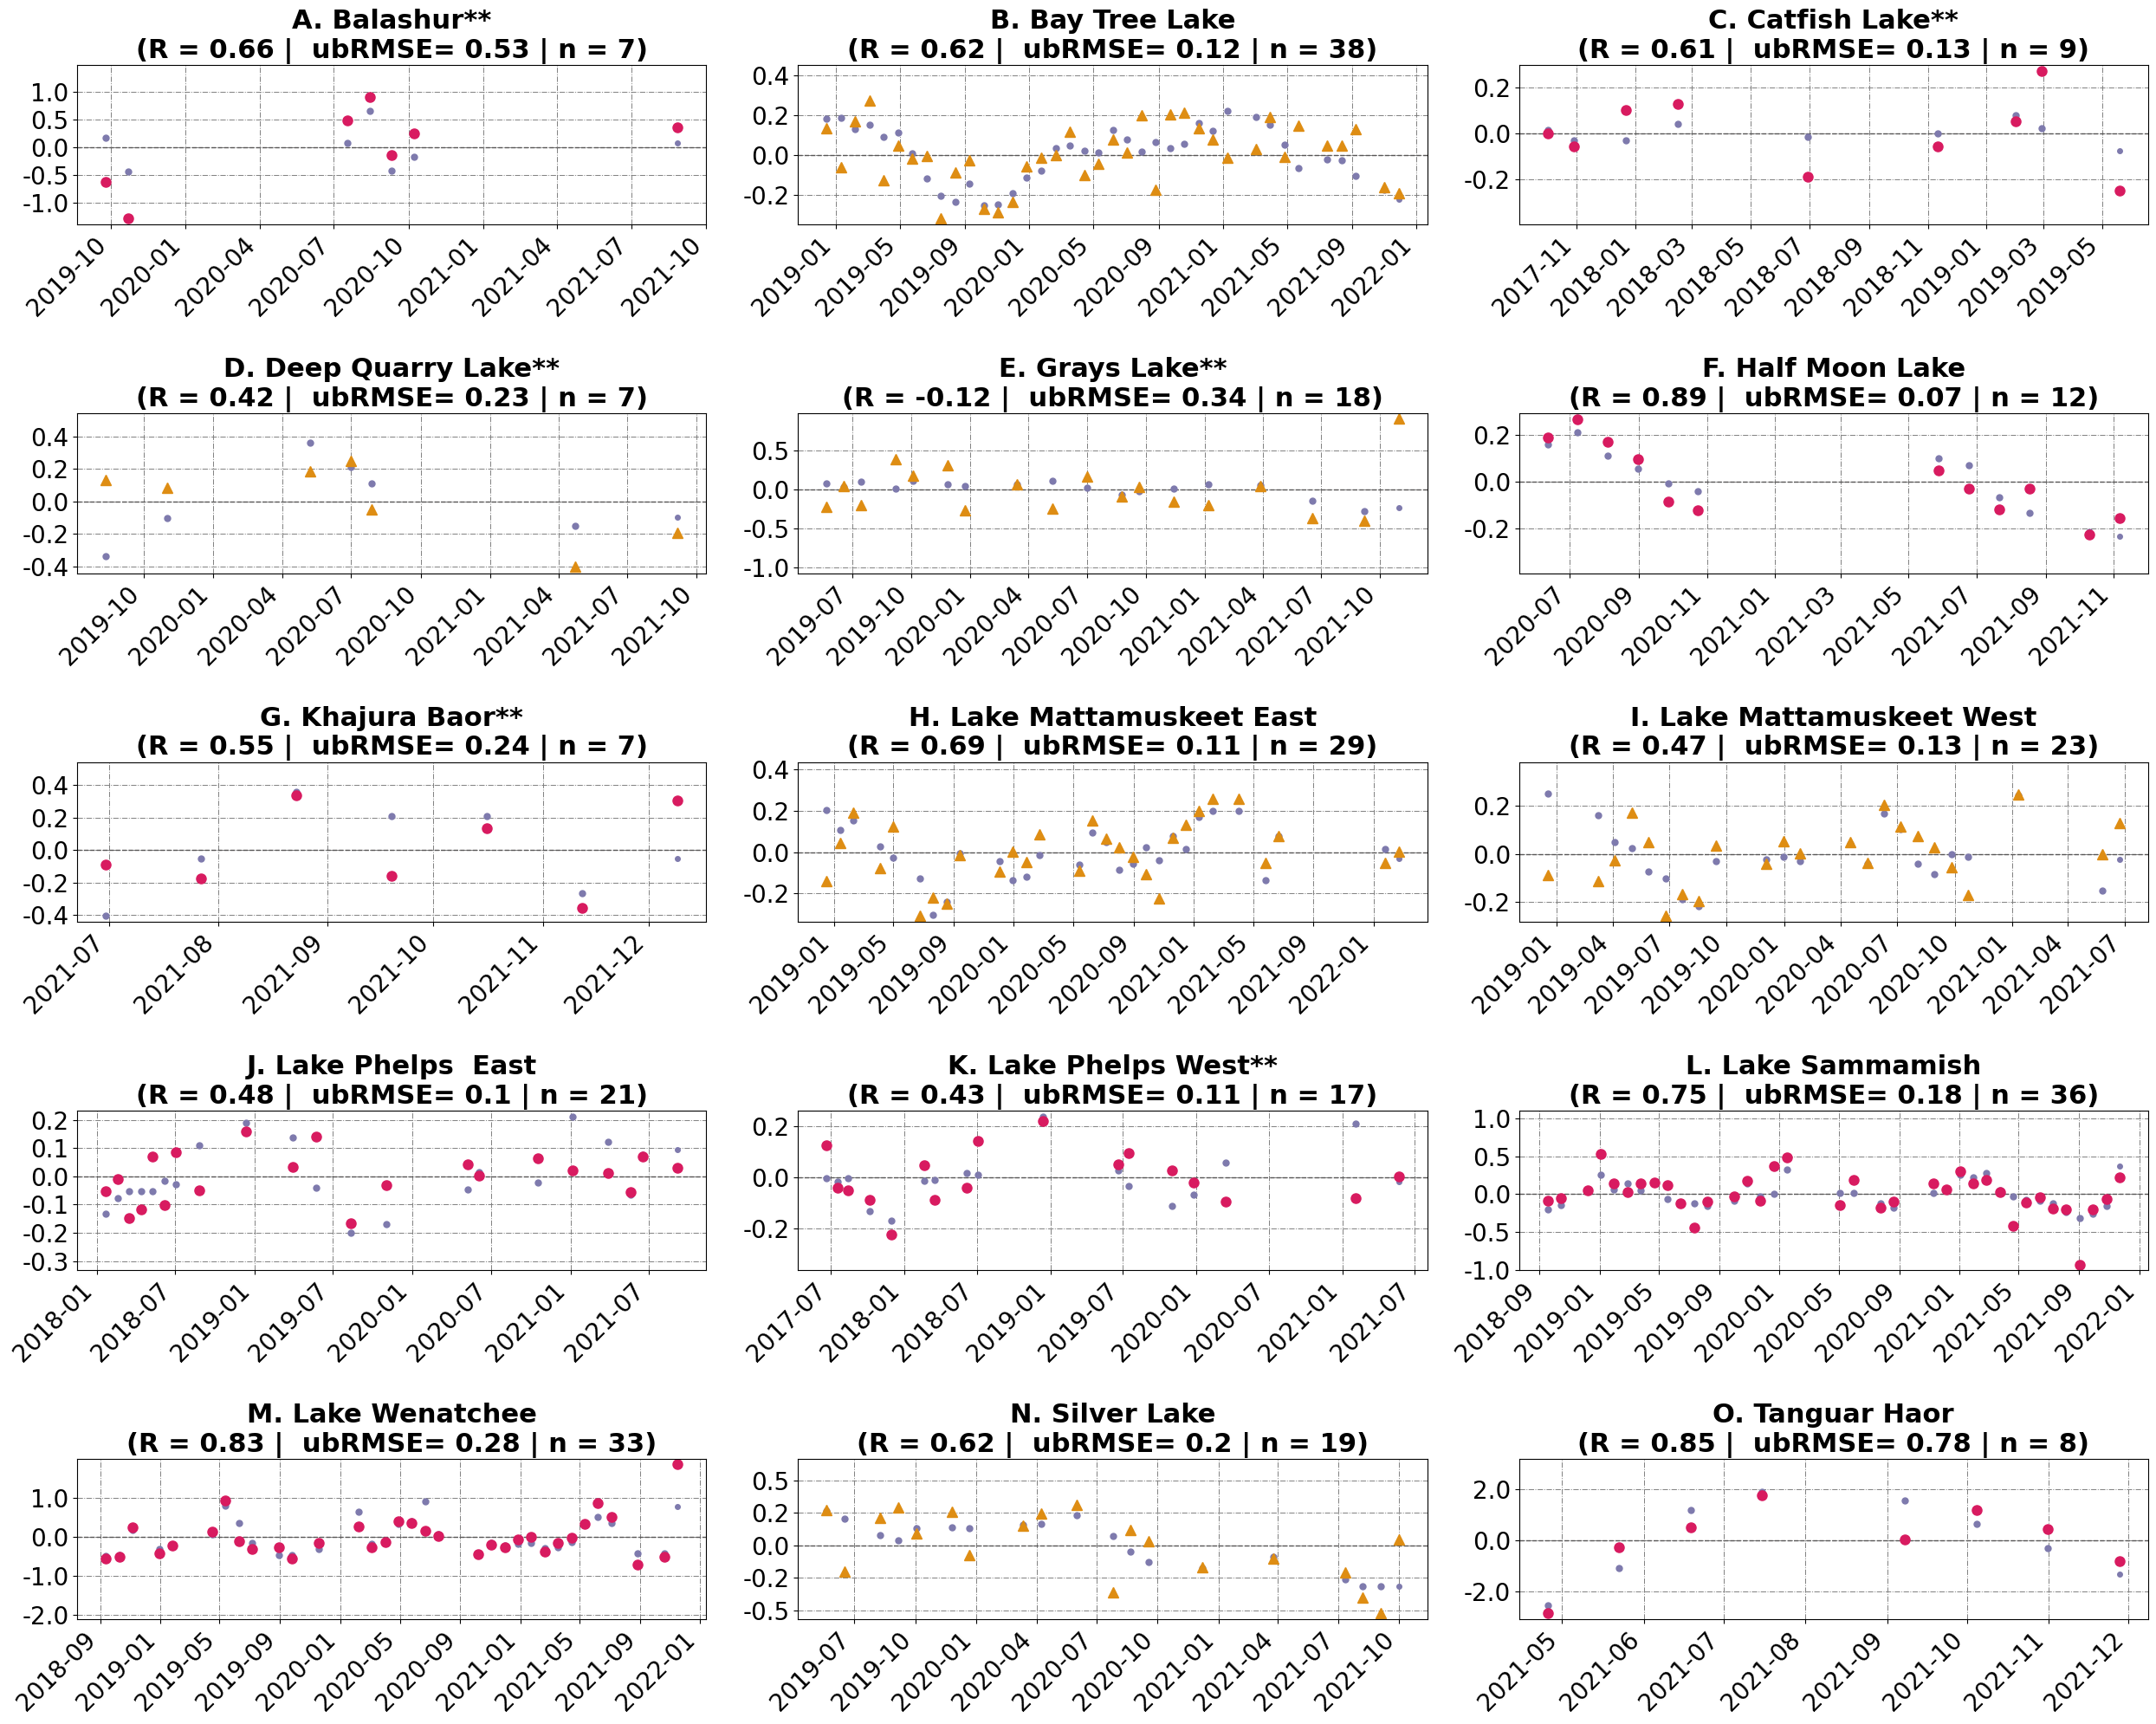

<Figure size 6000x10000 with 0 Axes>

In [49]:
#Test to determine potential number of figures
#path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


# if platform.system()=='Linux':
#     altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
# else:
#     altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  



time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_cd_'+group+'_'+time_fig+'/'



for ws in range(5,6):
    if start==0:
        df_cm=pd.DataFrame()
    

    # path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
    lon_fd='lon'
    lat_fd='lat'


    st_fd='gauge_id'
    # st_date_fd='date'
    altis_date_fd = 'date'  # Same value for Sentinel-3A/B
    # altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # nodataalti=-9999

    # wse_ref='e'
    j=1


    df_final_validation=df_validation.copy()#.loc[df_validation['source']==group].copy()
        # group='ALL'

    data_source=group

    # altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
    # #filter only altis time series with ground observations
    # altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

    fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
    axs=axs.ravel()
    x_ax=0
    y_ax=0
    c=0
    df_final_validation=df_final_validation.sort_values(by='lake_name')
    val_fd='val_cd_d_'+str(ws) #Closest

    # val_fd='median_d_5' #median between the values
    altis_data_fd='height'
    lake_name_fd='lake_name'
    g_gauge_id_fd='gauge_id'
    altis_name_fd='gauge_altis'
    source_fd='source'
    n_altis_obs_fd='nobs_altis'
    lake_id_fd='lake_id'
    orbit_fd='orbit'

    for altis in df_final_validation[altis_name_fd].unique():


        #Sel altis
        df_altis_c=df_final_validation.loc[df_final_validation[altis_name_fd]==altis].copy()

        #Get lake name and station
        lake_name=df_altis_c[lake_name_fd].iloc[0]
        lake_id=df_altis_c[lake_id_fd].iloc[0]
        gauge_id=df_altis_c[st_fd].iloc[0]
        go_source=df_altis_c[source_fd].iloc[0]
        df_ground_c=df_ground_cp.loc[df_ground_cp[altis_name_fd]==altis]
        name_altis=df_ground_c.name_altis.iloc[0]
        orbit_altis=df_altis_c[orbit_fd].iloc[0]
        altis_name=altis
        if 'Sentinel-3A' in name_altis:
            sot=str(lake_id)+'_S3A_'+str(orbit_altis)+'_1'
        elif 'Sentinel-3B' in name_altis:
            sot=str(lake_id)+'_S3B_'+str(orbit_altis)+'_1'
        else:
            sot=str(lake_id)+'_J3_'+str(orbit_altis)+'_1'
        print(sot)
        #get total of altimeter observations
        n_altis_obs=df_altis_c[[altis_name_fd, n_altis_obs_fd]].groupby(altis_name_fd).sum().reset_index()[n_altis_obs_fd].iloc[0]

        # get metrics 
        metrics=get_comp_metrics(ts_obs=df_altis_c[val_fd].to_numpy(),ts_est=df_altis_c[altis_data_fd].to_numpy())

        #Add coef variation of the observations

        cv=np.nanstd(df_altis_c[val_fd].to_numpy())/np.nanmean(df_altis_c[val_fd].to_numpy())*100
        std_obs=np.nanstd(df_altis_c[val_fd].to_numpy())
        mean_obs=np.nanmean(df_altis_c[val_fd].to_numpy())

        # Add to the output dataframe the range of dates of analysis in UTC
        altis_min_utc_date=df_altis_c[altis_date_fd].dt.normalize().min()
        altis_max_utc_date=df_altis_c[altis_date_fd].dt.normalize().max()
        # ground_min_utc_date=df_ground_c[altis_date_fd].dt.normalize().min()
        # ground_max_utc_date=df_ground_c[altis_date_fd].dt.normalize().max()
        #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)

        #Flashiness index 

        sum_swe=df_altis_c[val_fd].sum()
        diff_swe=np.abs(df_altis_c[val_fd].diff()).sum()
        rb_index=diff_swe/sum_swe

        # Standard deviation of the differences. Coefficient of variation of the differences
        #https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
        #I'll save the std of the diffences and the mean of the differences separated
        #sd(diff(x))/abs(mean(diff(x)))
        std_diff=np.nanstd(df_altis_c[val_fd].diff().to_numpy())
        mean_diff=np.nanmean(df_altis_c[val_fd].diff().to_numpy())


        #Create a output dataframe with the metrics
        cm_dict={'result_id':j,'station':[gauge_id],'lake_name':lake_name, 'lake_id':lake_id,'altis':[altis_name],'name_altis':name_altis, 'n_obs_altis':n_altis_obs,
                 'source':[go_source], 'method':['Closer value around date'], 'orbit':[orbit_altis],
                'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
                'ME':metrics['me'],'ME_Bias_Cor':metrics['me_bias_corr'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
                'rb_index':rb_index,'std_diff':std_diff,'std_obs':std_obs, 'mean_obs':mean_obs,
                'mean_diff':mean_diff, 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,
                'ts_sot':sot}#,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}


        df_cmi=pd.DataFrame(cm_dict)

        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        #df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        #df_ground_cp=pd.concat((df_ground_cp,df_ground_c), axis=0)
        # print('error', me_alti_insi)
        #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
        error_m_text='\n(R = '+str(np.round(cm_dict['R'], decimals=2))+' | '+\
        ' ubRMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
        # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

        labels=altis_name.split('_')[2]
        # labelg=' '+gauge_id
        labelg=letters[j-1]+'. '+lake_name
        labeli='Interp ground to altis'



        dfg=df_ground_c.copy()
        height_plot_fd_g='height'
        
        
        
        dfs=df_altis_c.dropna(subset=[val_fd, 'height']).copy()
        # dfs=df_altis_c

        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


        date_plot_fd='date'#'decimal_y'
        height_plot_fd='height'
        
        
        #For some new reason as in 02/22/2024 convert date to datetime
        dfg[date_plot_fd]=pd.to_datetime(dfg[date_plot_fd], format='ISO8601')
        
        if wtp=='mp':
            height_plot_fd_g=val_fd
            dfg=dfs
            plot_dots='_macthing_dots_'
        elif wtp=='gp':
            plot_dots='_allground_' #Other possibility _macthing_dots_
            
        nfig=j
        if metrics['PR_p_val']>=0.05:
            labelg=labelg+'**'
        if show_plot:
            #Add ice covered
            fill_between=None #{'fill':'SLIDE_snowIce',
                              #'lim':0.5}
            
            plt.subplot(row_f,col_f,nfig)
    #             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot
            plt=plot_dev_mean_publish(fig,nfig,dfs, dfg, go_source, gauge_id, altis_name, date_plot_fd, height_plot_fd_g, height_plot_fd, labels, labelg, fill_between, error_m_text)
            print(j, altis)

            j=j+1
    if save_plot:     
        
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')#, dpi=300, format='png')   
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.pdf', format='pdf')   
        print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')
    if show_plot:
        plt.figure(figsize=(60,100))
        plt.show() 

    df_final_validation['method']='Moving Window'
    # df_ground_cp['method']='Moving Window'


    #Save results
    if save_res:
        # ic(df_cm.head())
        #Save comparison metrics 
        df_cm['R']=[np.round(v, decimals=3) for v in df_cm['R']]
        df_cm['RHO']=[np.round(v, decimals=3) for v in df_cm['RHO']]
        df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
        df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
        df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
        #df_cm['ME']=[np.round(v, decimals=3) for v in df_cm['ME']]
        df_cm['VE']=[np.round(v, decimals=3) for v in df_cm['VE']]
        df_cm['n_obs']=[np.round(v, decimals=3) for v in df_cm['number_obs']]
        df_cm['cv_obs']=[np.round(v, decimals=3) for v in df_cm['cv_obs']]
        


        cols=['result_id','station','lake_id','lake_name', 'altis', 'name_altis','source', 'method','orbit','n_obs_altis','R','PR_pvalue','RHO','RHO_pvalue','NSF','RMSE', 'APL', 'ME','ME_Bias_Cor','VE','cv_obs','std_obs','mean_obs', 'n_obs','rb_index','std_diff','mean_diff','sat_min_utcdate','sat_max_utcdate', 'ts_sot']#, 'grd_min_utcdate','grd_max_utcdate']     
        df_cm[cols].to_csv('../data/results/comparison_'+group+'_'+time_fig+'.csv', sep=',')
        print('Data save to:\n','../data/results/comparison_'+group+'_'+time_fig+'.csv')



## Plot special cases

### OLTC problem in Atalho
### Filtering Araras time series 

In [50]:
filtered_gauge='12030'
df=df_final_altis.loc[df_final_altis['gauge_id'].isin([filtered_gauge])].copy()
df['gauge_altis']=df.gauge_id +'_'+df.name_altis
df.loc[df['gauge_id']==filtered_gauge,'lake_name']=dic_lake_names[filtered_gauge]
# df=df.loc[df['date']>'2018-07-01']
row_f=2
col_f=2
w=15
h=8

df_ground_cp=df_final_ground.loc[df_final_ground['for_paper']=='Y'].copy()
# df_ground_cp=df_ground_cp.loc[df_ground_cp['date']>'2018-07-01']
df_ground_cp['gauge_altis']=df_ground_cp.gauge_id +'_'+df_ground_cp.name_altis
df_final_ground['gauge_altis']=df_final_ground.gauge_id +'_'+df_final_ground.name_altis
df_validation=df.copy()

12030_J3_44_1
1 12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420
12030_J3_44_1
2 12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424
12030_S3A_52_1
3 12030_AlTiS_TimeSeries_Sentinel-3A_0104_S0424
12030_S3A_131_1
4 12030_AlTiS_TimeSeries_Sentinel-3A_0261_S0424
Figure save to:
 ../data/results/LOCSS_20240329_15_40_closest_icgt_Araras_5.png


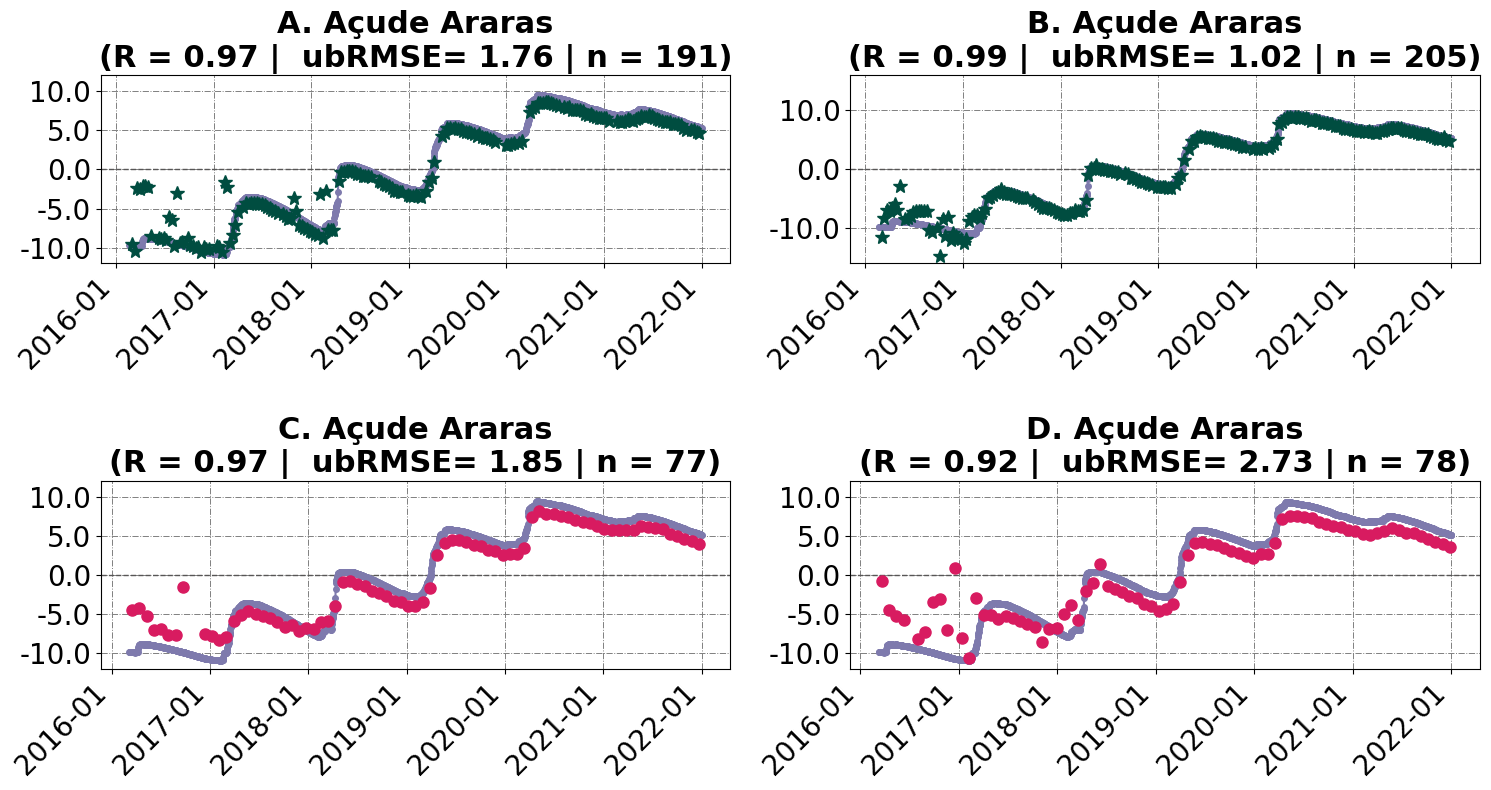

<Figure size 6000x10000 with 0 Axes>

In [51]:
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_cd_'+group+'_'+time_fig+'/'
plot_dots='_Araras_'
df_validation=df.copy()
for ws in range(5,6):
    if start==0:
        df_cm=pd.DataFrame()
    
    lon_fd='lon'
    lat_fd='lat'


    st_fd='gauge_id'
    # st_date_fd='date'
    altis_date_fd = 'date'  # Same value for Sentinel-3A/B
    # altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # nodataalti=-9999

    # wse_ref='e'
    j=1


    df_final_validation=df_validation.copy()#.loc[df_validation['source']==group].copy()
        # group='ALL'

    data_source=group

    # altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
    # #filter only altis time series with ground observations
    # altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

    fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
    axs=axs.ravel()
    x_ax=0
    y_ax=0
    c=0
    df_final_validation=df_final_validation.sort_values(by='lake_name')
    val_fd='val_cd_d_'+str(ws) #Closest

    # val_fd='median_d_5' #median between the values
    altis_data_fd='height'
    lake_name_fd='lake_name'
    g_gauge_id_fd='gauge_id'
    altis_name_fd='gauge_altis'
    source_fd='source'
    n_altis_obs_fd='nobs_altis'
    lake_id_fd='lake_id'
    orbit_fd='orbit'

    for altis in df_final_validation[altis_name_fd].unique():


        #Sel altis
        df_altis_c=df_final_validation.loc[df_final_validation[altis_name_fd]==altis].copy()

        #Get lake name and station
        lake_name=df_altis_c[lake_name_fd].iloc[0]
        lake_id=df_altis_c[lake_id_fd].iloc[0]
        gauge_id=df_altis_c[st_fd].iloc[0]
        go_source=df_altis_c[source_fd].iloc[0]
        df_ground_c=df_ground_cp.loc[df_ground_cp[altis_name_fd]==altis]
        name_altis=df_ground_c.name_altis.iloc[0]
        orbit_altis=df_altis_c[orbit_fd].iloc[0]
        altis_name=altis
        if 'Sentinel-3A' in name_altis:
            sot=str(lake_id)+'_S3A_'+str(orbit_altis)+'_1'
        elif 'Sentinel-3B' in name_altis:
            sot=str(lake_id)+'_S3B_'+str(orbit_altis)+'_1'
        else:
            sot=str(lake_id)+'_J3_'+str(orbit_altis)+'_1'
        print(sot)
        #get total of altimeter observations
        n_altis_obs=df_altis_c[[altis_name_fd, n_altis_obs_fd]].groupby(altis_name_fd).sum().reset_index()[n_altis_obs_fd].iloc[0]

        # get metrics 
        metrics=get_comp_metrics(ts_obs=df_altis_c[val_fd].to_numpy(),ts_est=df_altis_c[altis_data_fd].to_numpy())

        #Add coef variation of the observations

        cv=np.nanstd(df_altis_c[val_fd].to_numpy())/np.nanmean(df_altis_c[val_fd].to_numpy())*100
        std_obs=np.nanstd(df_altis_c[val_fd].to_numpy())
        mean_obs=np.nanmean(df_altis_c[val_fd].to_numpy())

        # Add to the output dataframe the range of dates of analysis in UTC
        altis_min_utc_date=df_altis_c[altis_date_fd].dt.normalize().min()
        altis_max_utc_date=df_altis_c[altis_date_fd].dt.normalize().max()
        # ground_min_utc_date=df_ground_c[altis_date_fd].dt.normalize().min()
        # ground_max_utc_date=df_ground_c[altis_date_fd].dt.normalize().max()
        #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)

        #Flashiness index 

        sum_swe=df_altis_c[val_fd].sum()
        diff_swe=np.abs(df_altis_c[val_fd].diff()).sum()
        rb_index=diff_swe/sum_swe

        # Standard deviation of the differences. Coefficient of variation of the differences
        #https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
        #I'll save the std of the diffences and the mean of the differences separated
        #sd(diff(x))/abs(mean(diff(x)))
        std_diff=np.nanstd(df_altis_c[val_fd].diff().to_numpy())
        mean_diff=np.nanmean(df_altis_c[val_fd].diff().to_numpy())


        #Create a output dataframe with the metrics
        cm_dict={'result_id':j,'station':[gauge_id],'lake_name':lake_name, 'lake_id':lake_id,'altis':[altis_name],'name_altis':name_altis, 'n_obs_altis':n_altis_obs,
                 'source':[go_source], 'method':['Closer value around date'], 'orbit':[orbit_altis],
                'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
                'ME':metrics['me'],'ME_Bias_Cor':metrics['me_bias_corr'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
                'rb_index':rb_index,'std_diff':std_diff,'std_obs':std_obs, 'mean_obs':mean_obs,
                'mean_diff':mean_diff, 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,
                'ts_sot':sot}#,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}


        df_cmi=pd.DataFrame(cm_dict)

        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        #df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        #df_ground_cp=pd.concat((df_ground_cp,df_ground_c), axis=0)
        # print('error', me_alti_insi)
        #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
        error_m_text='\n(R = '+str(np.round(cm_dict['R'], decimals=2))+' | '+\
        ' ubRMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
        # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

        labels=altis_name.split('_')[2]
        # labelg=' '+gauge_id
        labelg=letters[j-1]+'. '+lake_name
        labeli='Interp ground to altis'



        dfg=df_ground_c.copy()
        dfg[date_plot_fd]=pd.to_datetime(dfg[date_plot_fd], format='ISO8601')
        dfs=df_altis_c.dropna(subset=[val_fd, 'height']).copy()
        # dfs=df_altis_c

        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


        date_plot_fd='date'#'decimal_y'
        height_plot_fd='height'
        height_plot_fd_g='height'
        # height_plot_fd_g=val_fd
        # dfg=dfs
        nfig=j
        if metrics['PR_p_val']>=0.05:
            labelg=labelg+'**'
        if show_plot:
            #Add ice covered
            fill_between=None #{'fill':'SLIDE_snowIce',
                              #'lim':0.5}
            plt.subplot(row_f,col_f,nfig)
    #             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot
            plt=plot_dev_mean_publish(fig,nfig,dfs, dfg, go_source, gauge_id, altis_name, date_plot_fd, height_plot_fd_g, height_plot_fd, labels, labelg, fill_between, error_m_text)
            print(j, altis)

            j=j+1
    if save_plot:     
         #Other possibility _macthing_dots_
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')#, dpi=300, format='png')   
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.pdf', format='pdf')   
        print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')
    if show_plot:
        plt.figure(figsize=(60,100))
        plt.show() 

    df_final_validation['method']='Moving Window'
    # df_ground_cp['method']='Moving Window'



In [52]:
# df_final_validation.loc[df_final_validation.index!=1030]

In [63]:
filtered_gauge='12036'
df=df_final_altis.loc[df_final_altis['gauge_id'].isin([filtered_gauge])].copy()
df['gauge_altis']=df.gauge_id +'_'+df.name_altis
df.loc[df['gauge_id']==filtered_gauge,'lake_name']=dic_lake_names[filtered_gauge]
# df=df.loc[df['date']>'2018-07-01']
row_f=2
col_f=2
w=15
h=8

df_ground_cp=df_final_ground.loc[df_final_ground['for_paper']=='Y'].copy()
# df_ground_cp=df_ground_cp.loc[df_ground_cp['date']>'2018-07-01']
df_ground_cp['gauge_altis']=df_ground_cp.gauge_id +'_'+df_ground_cp.name_altis
df_final_ground['gauge_altis']=df_final_ground.gauge_id +'_'+df_final_ground.name_altis
df_validation=df.copy()

12036_J3_82_1
1 12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764
12036_J3_82_1
2 12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764
12036_S3B_223_1
3 12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765
Figure save to:
 ../data/results/LOCSS_20240329_16_43_closest_icgt_Atalho_5.png


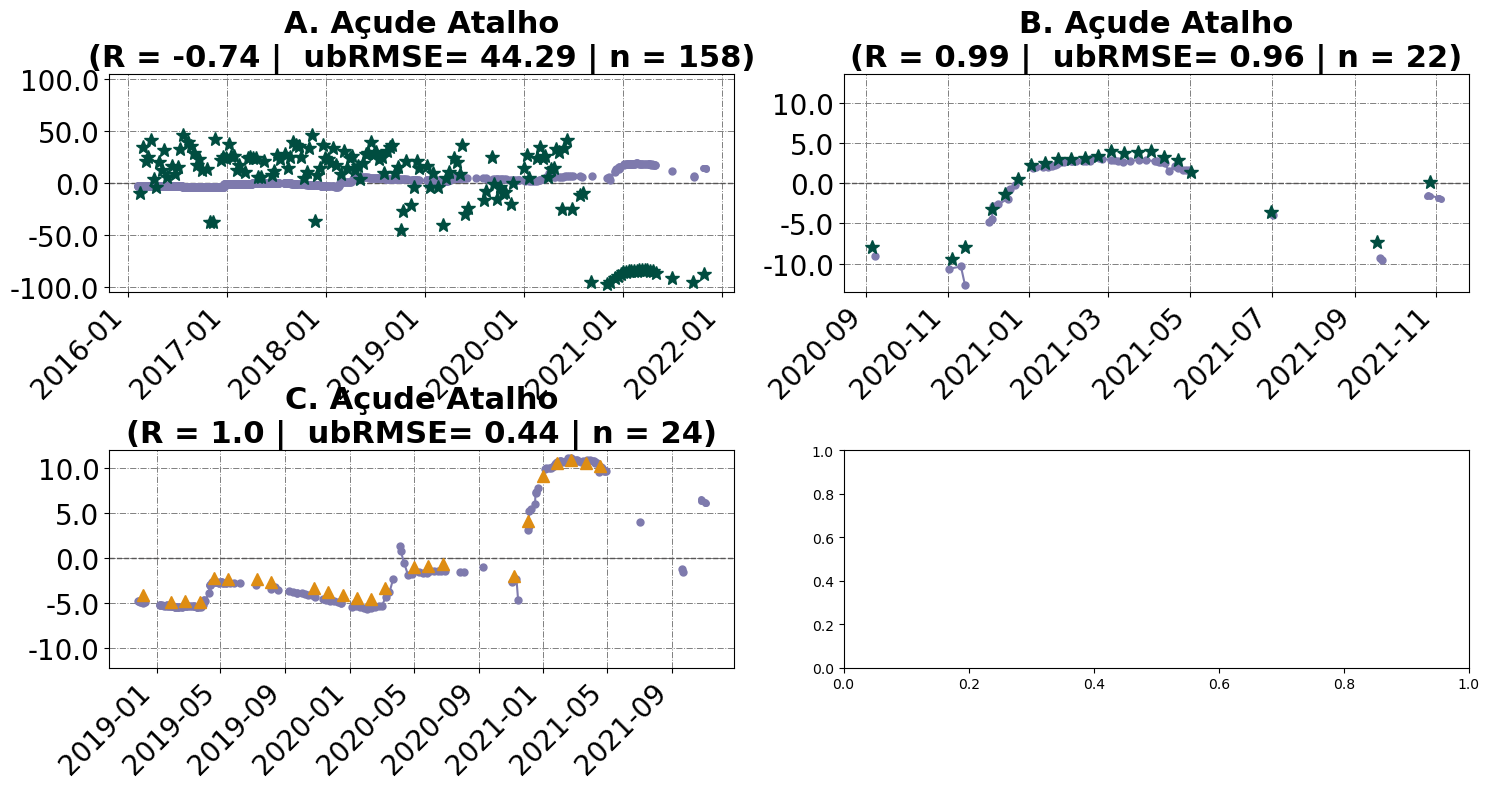

<Figure size 6000x10000 with 0 Axes>

In [64]:
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_cd_'+group+'_'+time_fig+'/'
plot_dots='_Atalho_'
df_validation=df.copy()
for ws in range(5,6):
    if start==0:
        df_cm=pd.DataFrame()
    
    lon_fd='lon'
    lat_fd='lat'


    st_fd='gauge_id'
    # st_date_fd='date'
    altis_date_fd = 'date'  # Same value for Sentinel-3A/B
    # altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # nodataalti=-9999

    # wse_ref='e'
    j=1


    df_final_validation=df_validation.copy()#.loc[df_validation['source']==group].copy()
        # group='ALL'

    data_source=group

    # altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
    # #filter only altis time series with ground observations
    # altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

    fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
    axs=axs.ravel()
    x_ax=0
    y_ax=0
    c=0
    df_final_validation=df_final_validation.sort_values(by='lake_name')
    val_fd='val_cd_d_'+str(ws) #Closest

    # val_fd='median_d_5' #median between the values
    altis_data_fd='height'
    lake_name_fd='lake_name'
    g_gauge_id_fd='gauge_id'
    altis_name_fd='gauge_altis'
    source_fd='source'
    n_altis_obs_fd='nobs_altis'
    lake_id_fd='lake_id'
    orbit_fd='orbit'

    for altis in df_final_validation[altis_name_fd].unique():


        #Sel altis
        df_altis_c=df_final_validation.loc[df_final_validation[altis_name_fd]==altis].copy()

        #Get lake name and station
        lake_name=df_altis_c[lake_name_fd].iloc[0]
        lake_id=df_altis_c[lake_id_fd].iloc[0]
        gauge_id=df_altis_c[st_fd].iloc[0]
        go_source=df_altis_c[source_fd].iloc[0]
        df_ground_c=df_ground_cp.loc[df_ground_cp[altis_name_fd]==altis]
        name_altis=df_ground_c.name_altis.iloc[0]
        orbit_altis=df_altis_c[orbit_fd].iloc[0]
        altis_name=altis
        if 'Sentinel-3A' in name_altis:
            sot=str(lake_id)+'_S3A_'+str(orbit_altis)+'_1'
        elif 'Sentinel-3B' in name_altis:
            sot=str(lake_id)+'_S3B_'+str(orbit_altis)+'_1'
        else:
            sot=str(lake_id)+'_J3_'+str(orbit_altis)+'_1'
        print(sot)
        #get total of altimeter observations
        n_altis_obs=df_altis_c[[altis_name_fd, n_altis_obs_fd]].groupby(altis_name_fd).sum().reset_index()[n_altis_obs_fd].iloc[0]

        # get metrics 
        metrics=get_comp_metrics(ts_obs=df_altis_c[val_fd].to_numpy(),ts_est=df_altis_c[altis_data_fd].to_numpy())

        #Add coef variation of the observations

        cv=np.nanstd(df_altis_c[val_fd].to_numpy())/np.nanmean(df_altis_c[val_fd].to_numpy())*100
        std_obs=np.nanstd(df_altis_c[val_fd].to_numpy())
        mean_obs=np.nanmean(df_altis_c[val_fd].to_numpy())

        # Add to the output dataframe the range of dates of analysis in UTC
        altis_min_utc_date=df_altis_c[altis_date_fd].dt.normalize().min()
        altis_max_utc_date=df_altis_c[altis_date_fd].dt.normalize().max()
        # ground_min_utc_date=df_ground_c[altis_date_fd].dt.normalize().min()
        # ground_max_utc_date=df_ground_c[altis_date_fd].dt.normalize().max()
        #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)

        #Flashiness index 

        sum_swe=df_altis_c[val_fd].sum()
        diff_swe=np.abs(df_altis_c[val_fd].diff()).sum()
        rb_index=diff_swe/sum_swe

        # Standard deviation of the differences. Coefficient of variation of the differences
        #https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
        #I'll save the std of the diffences and the mean of the differences separated
        #sd(diff(x))/abs(mean(diff(x)))
        std_diff=np.nanstd(df_altis_c[val_fd].diff().to_numpy())
        mean_diff=np.nanmean(df_altis_c[val_fd].diff().to_numpy())


        #Create a output dataframe with the metrics
        cm_dict={'result_id':j,'station':[gauge_id],'lake_name':lake_name, 'lake_id':lake_id,'altis':[altis_name],'name_altis':name_altis, 'n_obs_altis':n_altis_obs,
                 'source':[go_source], 'method':['Closer value around date'], 'orbit':[orbit_altis],
                'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
                'ME':metrics['me'],'ME_Bias_Cor':metrics['me_bias_corr'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
                'rb_index':rb_index,'std_diff':std_diff,'std_obs':std_obs, 'mean_obs':mean_obs,
                'mean_diff':mean_diff, 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,
                'ts_sot':sot}#,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}


        df_cmi=pd.DataFrame(cm_dict)

        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        #df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        #df_ground_cp=pd.concat((df_ground_cp,df_ground_c), axis=0)
        # print('error', me_alti_insi)
        #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
        error_m_text='\n(R = '+str(np.round(cm_dict['R'], decimals=2))+' | '+\
        ' ubRMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
        # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

        labels=altis_name.split('_')[2]
        # labelg=' '+gauge_id
        labelg=letters[j-1]+'. '+lake_name
        labeli='Interp ground to altis'



        dfg=df_ground_c.copy()
        dfg[date_plot_fd]=pd.to_datetime(dfg[date_plot_fd], format='ISO8601')
        dfs=df_altis_c.dropna(subset=[val_fd, 'height']).copy()
        # dfs=df_altis_c

        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


        date_plot_fd='date'#'decimal_y'
        height_plot_fd='height'
        height_plot_fd_g='height'
        # height_plot_fd_g=val_fd
        # dfg=dfs
        nfig=j
        if metrics['PR_p_val']>=0.05:
            labelg=labelg+'**'
        if show_plot:
            #Add ice covered
            fill_between=None #{'fill':'SLIDE_snowIce',
                              #'lim':0.5}
            plt.subplot(row_f,col_f,nfig)
    #             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot
            plt=plot_dev_mean_publish(fig,nfig,dfs, dfg, go_source, gauge_id, altis_name, date_plot_fd, height_plot_fd_g, height_plot_fd, labels, labelg, fill_between, error_m_text)
            print(j, altis)

            j=j+1
    if save_plot:     
        
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')#, dpi=300, format='png')   
        plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.pdf', format='pdf')   
        print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+plot_dots+str(ws)+'.png')
    if show_plot:
        plt.figure(figsize=(60,100))
        plt.show() 

    df_final_validation['method']='Moving Window'
    # df_ground_cp['method']='Moving Window'



1 12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764
2 12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764
3 12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765
Figure save to:
 ../data/results/LOCSS_20240329_16_38_closest_icgt5_Atalho.png


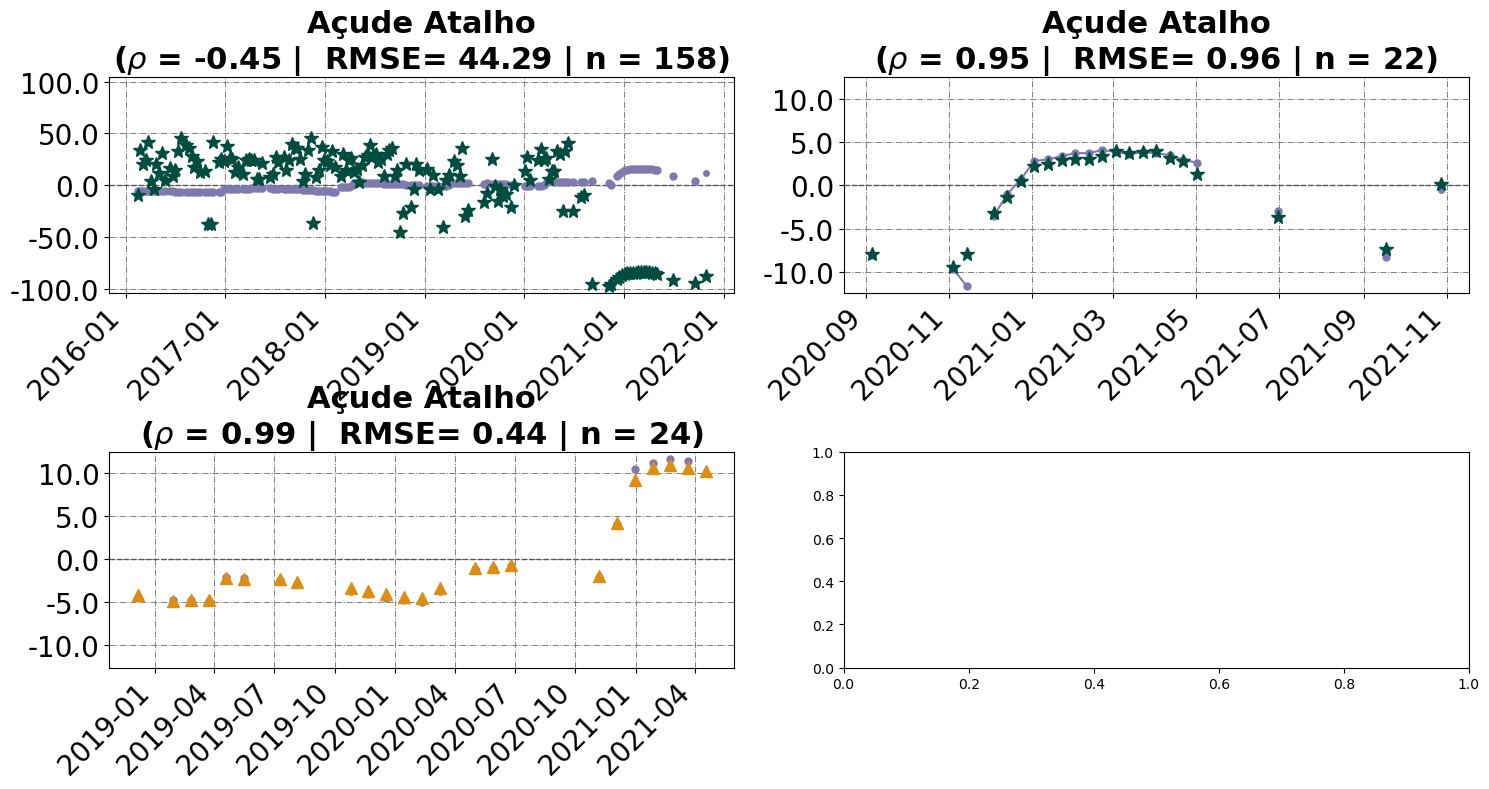

<Figure size 6000x10000 with 0 Axes>

'Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '

In [57]:
#Test to determine potential number of figures
#path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


# if platform.system()=='Linux':
#     altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
# else:
#     altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  



time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_cd_'+group+'_'+time_fig+'/'

if start==0:
    df_cm=pd.DataFrame()
    

# path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'


st_fd='gauge_id'
# st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
# altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
# nodataalti=-9999

# wse_ref='e'
j=1

# if group not in ['ALL', 'ICECV', '']:
#     df_final_validation=df_validation.loc[df_validation['source']==group].copy()
#     # group='ALL'
# else:
df_final_validation=df_validation.copy()
    # group='ALL'

data_source=group

# altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
# #filter only altis time series with ground observations
# altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
axs=axs.ravel()
x_ax=0
y_ax=0
c=0
df_final_validation=df_final_validation.sort_values(by='lake_name')


val_fd='val_cd_d_5' #Closest

# val_fd='median_d_5' #median between the values
altis_data_fd='height'
lake_name_fd='lake_name'
g_gauge_id_fd='gauge_id'
altis_name_fd='gauge_altis'
source_fd='source'
n_altis_obs_fd='nobs_altis'
lake_id_fd='lake_id'
orbit_fd='orbit'

for altis in df_final_validation[altis_name_fd].unique():
    

    #Sel altis
    df_altis_c=df_final_validation.loc[df_final_validation[altis_name_fd]==altis].copy()

    #Get lake name and station
    lake_name=df_altis_c[lake_name_fd].iloc[0]
    lake_id=df_altis_c[lake_id_fd].iloc[0]
    gauge_id=df_altis_c[st_fd].iloc[0]
    go_source=df_altis_c[source_fd].iloc[0]
    df_ground_c=df_ground_cp.loc[df_ground_cp[altis_name_fd]==altis]
    name_altis=df_ground_c.name_altis.iloc[0]
    orbit_altis=df_altis_c[orbit_fd].iloc[0]
    altis_name=altis
    #get total of altimeter observations
    n_altis_obs=df_altis_c[[altis_name_fd, n_altis_obs_fd]].groupby(altis_name_fd).sum().reset_index()[n_altis_obs_fd].iloc[0]
    
    # get metrics 
    metrics=get_comp_metrics(ts_obs=df_altis_c[val_fd].to_numpy(),ts_est=df_altis_c[altis_data_fd].to_numpy())
        
    #Add coef variation of the observations
        
    cv=np.nanstd(df_altis_c[val_fd].to_numpy())/np.nanmean(df_altis_c[val_fd].to_numpy())*100
    std_obs=np.nanstd(df_altis_c[val_fd].to_numpy())
    mean_obs=np.nanmean(df_altis_c[val_fd].to_numpy())
        
    # Add to the output dataframe the range of dates of analysis in UTC
    altis_min_utc_date=df_altis_c[altis_date_fd].dt.normalize().min()
    altis_max_utc_date=df_altis_c[altis_date_fd].dt.normalize().max()
    ground_min_utc_date=df_ground_c[altis_date_fd].dt.normalize().min()
    ground_max_utc_date=df_ground_c[altis_date_fd].dt.normalize().max()
    #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)
    
    #Flashiness index 
    
    sum_swe=df_altis_c[val_fd].sum()
    diff_swe=np.abs(df_altis_c[val_fd].diff()).sum()
    rb_index=diff_swe/sum_swe
    
    # Standard deviation of the differences. Coefficient of variation of the differences
    #https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
    #I'll save the std of the diffences and the mean of the differences separated
    #sd(diff(x))/abs(mean(diff(x)))
    std_diff=np.nanstd(df_altis_c[val_fd].diff().to_numpy())
    mean_diff=np.nanmean(df_altis_c[val_fd].diff().to_numpy())
    

    #Create a output dataframe with the metrics
    cm_dict={'result_id':j,'station':[gauge_id],'lake_name':lake_name, 'lake_id':lake_id,'altis':[altis_name],'name_altis':name_altis, 'n_obs_altis':n_altis_obs,
             'source':[go_source], 'method':['Closer value around date'], 'orbit':[orbit_altis],
            'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
            'ME':metrics['me'],'ME_Bias_Cor':metrics['me_bias_corr'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
            'rb_index':rb_index,'std_diff':std_diff,'std_obs':std_obs, 'mean_obs':mean_obs,
            'mean_diff':mean_diff, 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}


    df_cmi=pd.DataFrame(cm_dict)

    df_cm=pd.concat((df_cm,df_cmi), axis=0)
    #df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
    #df_ground_cp=pd.concat((df_ground_cp,df_ground_c), axis=0)
    # print('error', me_alti_insi)
    #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
    error_m_text='\n($\\rho$ = '+str(np.round(cm_dict['RHO'], decimals=2))+' | '+\
    ' RMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
    # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

    labels=altis_name.split('_')[2]
    # labelg=' '+gauge_id
    labelg=lake_name
    labeli='Interp ground to altis'



    dfg=df_ground_c
    dfs=df_altis_c.dropna(subset=[val_fd, 'height']).copy()
    # dfs=df_altis_c
    
    # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


    date_plot_fd='date'#'decimal_y'
    height_plot_fd='height'
    height_plot_fd_g=val_fd
    dfg=dfs
    nfig=j
    if show_plot:
        #Add ice covered
        fill_between=None #{'fill':'SLIDE_snowIce',
                          #'lim':0.5}
        plt.subplot(row_f,col_f,nfig)
#             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot
        plt=plot_dev_mean_publish(fig,nfig,dfs, dfg, go_source, gauge_id, altis_name, date_plot_fd, height_plot_fd_g, height_plot_fd, labels, labelg, fill_between, error_m_text)
        print(j, altis)
            
    j=j+1
if save_plot:     
    plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt0_Atalho.png')#, dpi=300, format='png')    
    print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_icgt5_Atalho.png')
    plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt'+str(ws)+'_Atalho.pdf', format='pdf')
if show_plot:
    plt.figure(figsize=(60,100))
    plt.show() 

df_final_validation['method']='Moving Window'
# df_ground_cp['method']='Moving Window'


#Save results
if save_res:
    # ic(df_cm.head())
    #Save comparison metrics 
    df_cm['R']=[np.round(v, decimals=3) for v in df_cm['R']]
    df_cm['RHO']=[np.round(v, decimals=3) for v in df_cm['RHO']]
    df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
    df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
    df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
    #df_cm['ME']=[np.round(v, decimals=3) for v in df_cm['ME']]
    df_cm['VE']=[np.round(v, decimals=3) for v in df_cm['VE']]
    df_cm['n_obs']=[np.round(v, decimals=3) for v in df_cm['number_obs']]
    df_cm['cv_obs']=[np.round(v, decimals=3) for v in df_cm['cv_obs']]

    
    cols=['result_id','station','lake_id','lake_name', 'altis', 'name_altis','source', 'method','orbit','n_obs_altis','R','PR_pvalue','RHO','RHO_pvalue','NSF','RMSE', 'APL', 'ME','ME_Bias_Cor','VE','cv_obs','std_obs','mean_obs', 'n_obs','rb_index','std_diff','mean_diff','sat_min_utcdate','sat_max_utcdate', 'grd_min_utcdate','grd_max_utcdate']     
    df_cm[cols].to_csv('../data/results/comparison_'+group+'_'+time_fig+'.csv', sep=',')
    print('Data save to:\n','../data/results/comparison_'+group+'_'+time_fig+'.csv')

'''Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '''

Figure save to:
 ../data/results/LOCSS_20240329_16_43_closest_xy_icgt0.png


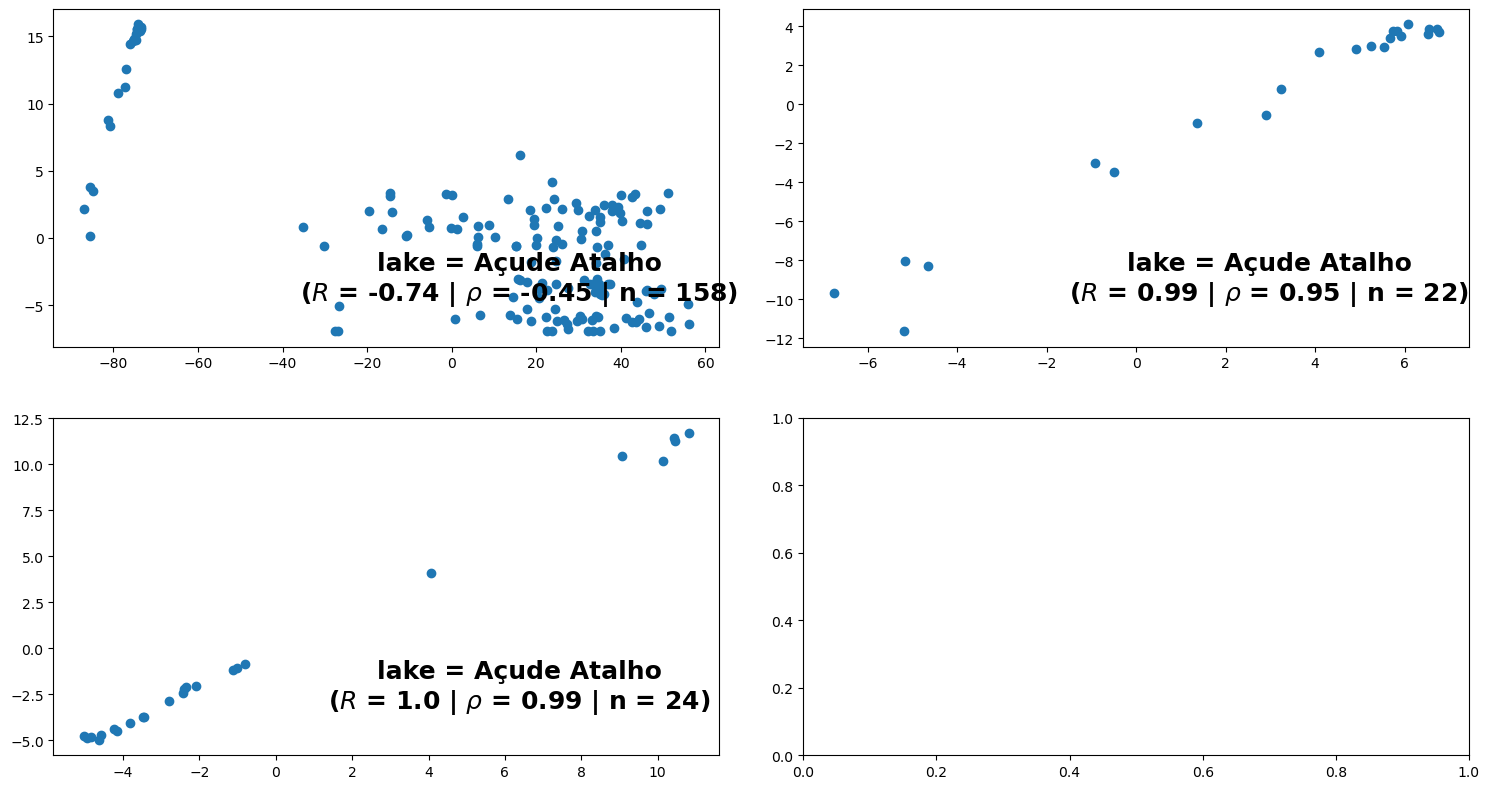

In [65]:
# om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
# # df_final_altis.columns


i=0
j=0
# row_f=9
# col_f=4
# w=30
# h=30

fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_validation[altis_name_fd].unique():
    df_val=df_final_validation.loc[df_final_validation[altis_name_fd]==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
       '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['number_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val[altis_data_fd]-np.mean(df_val[altis_data_fd]),df_val[val_fd]-np.mean(df_val[val_fd]))#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=18,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_xy_icgt0.png')#, dpi=300, format='svg')    
print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_xy_icgt0.png')    